In [3]:
import re
import csv

input_file = "Augmentations.ts"
output_file = "augmentations.csv"

# --- Step 1: Read and clean file ---
with open(input_file, "r", encoding="utf-8") as f:
    text = f.read()

# Remove comment lines
text = "\n".join(line for line in text.splitlines() if not line.strip().startswith("//"))

# --- Step 2: Match augmentation blocks ---
# This handles multiline and nested braces
augment_pattern = re.compile(
    r"\[AugmentationName\.(\w+)\]\s*:\s*\{(.*?)\n\s*\}", re.DOTALL
)
matches = augment_pattern.findall(text)

augmentations = []
all_factions = set()
all_keys = set(["name"])

# --- Step 3: Parse each augmentation ---
for name, body in matches:
    augment_data = {"name": name}

    # Normalize body (remove JS concatenations with "+")
    body = re.sub(r'"\s*\+\s*"', '', body)

    # Find all "key: value" pairs — including multiline arrays
    key_value_pattern = re.compile(r"(\w+):\s*(\[[^\]]*\]|[^,]+)", re.DOTALL)
    for key, raw_value in key_value_pattern.findall(body):
        value = raw_value.strip().rstrip(",")
        if key == "factions":
            # Extract all faction names across multiple lines
            factions = re.findall(r"FactionName\.(\w+)", value)
            augment_data["factions"] = factions
            all_factions.update(factions)
        else:
            # Keep all other values as-is (stringified)
            augment_data[key] = " ".join(value.split())
            all_keys.add(key)

    augmentations.append(augment_data)

# --- Step 4: Build CSV columns ---
columns = sorted(all_keys - {"factions"}) + sorted(all_factions)

# --- Step 5: Write CSV ---
with open(output_file, "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=columns)
    writer.writeheader()

    for aug in augmentations:
        row = {}
        for c in columns:
            if c in aug:
                row[c] = aug[c]
            elif c in all_factions:
                row[c] = 1 if c in aug.get("factions", []) else 0
            else:
                row[c] = ""
        writer.writerow(row)

print(f"✅ Parsed {len(augmentations)} augmentations into {output_file}")


✅ Parsed 123 augmentations into augmentations.csv


lambertw_samples = np.array([
    [0.00000000, 0.000000000000000],
    [0.02495530, 0.024354855997217],
    [0.05434970, 0.051615577390269],
    [0.08757182, 0.080776247872532],
    [0.12535780, 0.112067821657710],
    [0.16869307, 0.145805735012979],
    [0.21879132, 0.182325399520030],
    [0.27728220, 0.222065116634531],
    [0.34632974, 0.265558008976471],
    [0.42890817, 0.313486511873767],
    [0.52917836, 0.366721859065685],
    [0.65316628, 0.426416103023714],
    [0.80989661, 0.494122709514507],
    [1.01353694, 0.572022714693496],
    [1.28754076, 0.663284810976633],
    [1.67369147, 0.772785459796716],
    [2.25396607, 0.908572240768204],
    [3.21313298, 1.085346852026272],
    [5.06881525, 1.334528823666773],
    [10.00000000, 1.745528002740699],
])



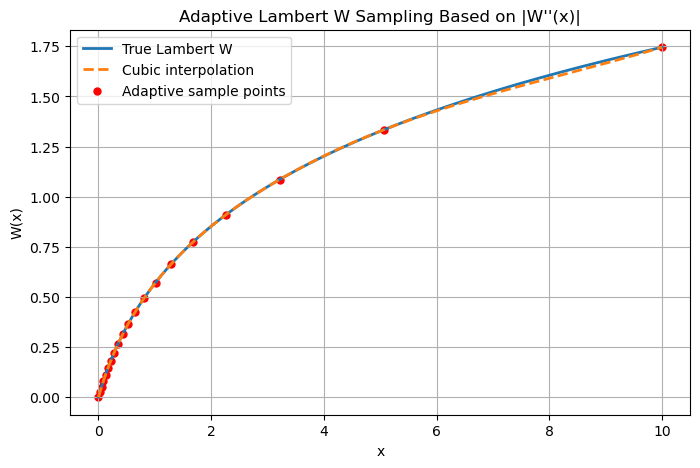

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import lambertw
from scipy.interpolate import interp1d

# === Parameters ===
START = 0.0
END = 10.0
NUM_POINTS = 20  # total number of samples

# === Compute curvature weighting ===
x_dense = np.linspace(START, END, 2000)
W = lambertw(x_dense).real

# numerical first and second derivatives
dx = x_dense[1] - x_dense[0]
W_prime = np.gradient(W, dx)
W_double = np.gradient(W_prime, dx)

# weighting proportional to |W''(x)| + constant to avoid zeros
weight = np.abs(W_double) + 1e-6
# normalize weights to integrate to 1
cdf = np.cumsum(weight)
cdf /= cdf[-1]

# === Choose nonuniform sample positions ===
# target quantiles (uniform in cumulative weight)
quantiles = np.linspace(0, 1, NUM_POINTS)
x_points = np.interp(quantiles, cdf, x_dense)
w_points = lambertw(x_points).real

# combine into single array
lambertw_samples = np.column_stack((x_points, w_points))

# print the array as literal Python code
print("lambertw_samples = np.array([")
for x, w in lambertw_samples:
    print(f"    [{x:.8f}, {w:.15f}],")
print("])\n")

# === Optional: build an interpolator (for testing) ===
approx_W = interp1d(x_points, w_points, kind="cubic", fill_value="extrapolate")
x_test = np.linspace(START, END, 1000)
true_W = lambertw(x_test).real
approx_vals = approx_W(x_test)

# === Plot results ===
plt.figure(figsize=(8, 5))
plt.plot(x_test, true_W, label="True Lambert W", linewidth=2)
plt.plot(x_test, approx_vals, "--", label="Cubic interpolation", linewidth=2)
plt.scatter(x_points, w_points, color="red", s=25, label="Adaptive sample points")
plt.title("Adaptive Lambert W Sampling Based on |W''(x)|")
plt.xlabel("x")
plt.ylabel("W(x)")
plt.legend()
plt.grid(True)
plt.show()

In [5]:
for x, w in lambertw_samples:
    print(w)

0.0
0.0243548559972167
0.05161557739026885
0.0807762478725318
0.11206782165771038
0.14580573501297925
0.18232539952002985
0.2220651166345314
0.2655580089764711
0.31348651187376675
0.3667218590656851
0.42641610302371447
0.4941227095145066
0.5720227146934959
0.6632848109766334
0.772785459796716
0.908572240768204
1.085346852026272
1.334528823666773
1.7455280027406994


In [3]:
import math

class SeedCandidate:
    def __init__(self, initial_state):
        self.s1 = initial_state
        self.s2 = initial_state
        self.s3 = initial_state
    
    def step(self):
        self.s1 = (171 * self.s1) % 30269
        self.s2 = (172 * self.s2) % 30307
        self.s3 = (170 * self.s3) % 30323
    
    def random(self):
        self.step()
        return (self.s1 / 30269 + self.s2 / 30307 + self.s3 / 30323) % 1
    
    @property
    def next(self):
        return math.floor(self.random() * 37)

# Usage:
seed = SeedCandidate(14616.566999912262)
print(seed.next)  # Returns roulette outcome 0-36
print(seed.s1)
print(seed.s2)
print(seed.s3)
print(seed.next)
print(seed.s1)
print(seed.s2)
print(seed.s3)

17
17374.956984996796
28875.523984909058
28653.389985084534
24
4755.644434452057
26549.12540435791
19396.297464370728
